In [7]:
from qiskit import *
from qiskit.visualization import *
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_distribution
from qiskit.circuit import ParameterVector

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

import warnings


In [16]:
def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
            
    ### Write your code below here ###
    qc = QuantumCircuit(num_qubits)
    if bird_index < 5:
        generate_GHZ(qc)

    bit_str = format(bird_index, "0{0}b".format(num_qubits))
    for i in reversed(range(len(bit_str))):
        bit = bit_str[i]
        if bit == '1':
            qc.x(i)
    qc = qc.reverse_bits()
    
    ### Don't change any code past this line ###
    return qc

In [22]:
bird_index = 2
num_qubits = 5

bit_str = format(bird_index, "0{0}b".format(num_qubits))
print (bit_str)

print (f'x =%s, %f' % ('a', 1))

#qc = amplitude_embedding(num_qubits, bird_index)
#qc.draw()

00010
x =a, 1.000000


In [8]:
def ghz (n):

    qc = QuantumCircuit(n)
    
    # Create a bell pair
    qc.h(0)
    qc.cx(0, 1)
    
    index = 2  # Index of a target qubit
    qubits = [0, 1]  # Qubits which are already entangled
    
    while len(qubits) < n:
        temp_qubits = []
    
        # Entangle the remaining qubits with already entangled qubits
        for qubit in qubits:
            qc.cx(qubit, index)
            temp_qubits.append(index)
            index += 1
            if index >= n:
                break
    
        qubits += temp_qubits  # Update the entangled qubits list    
    return qc

Depth of two-qubit gates:  44


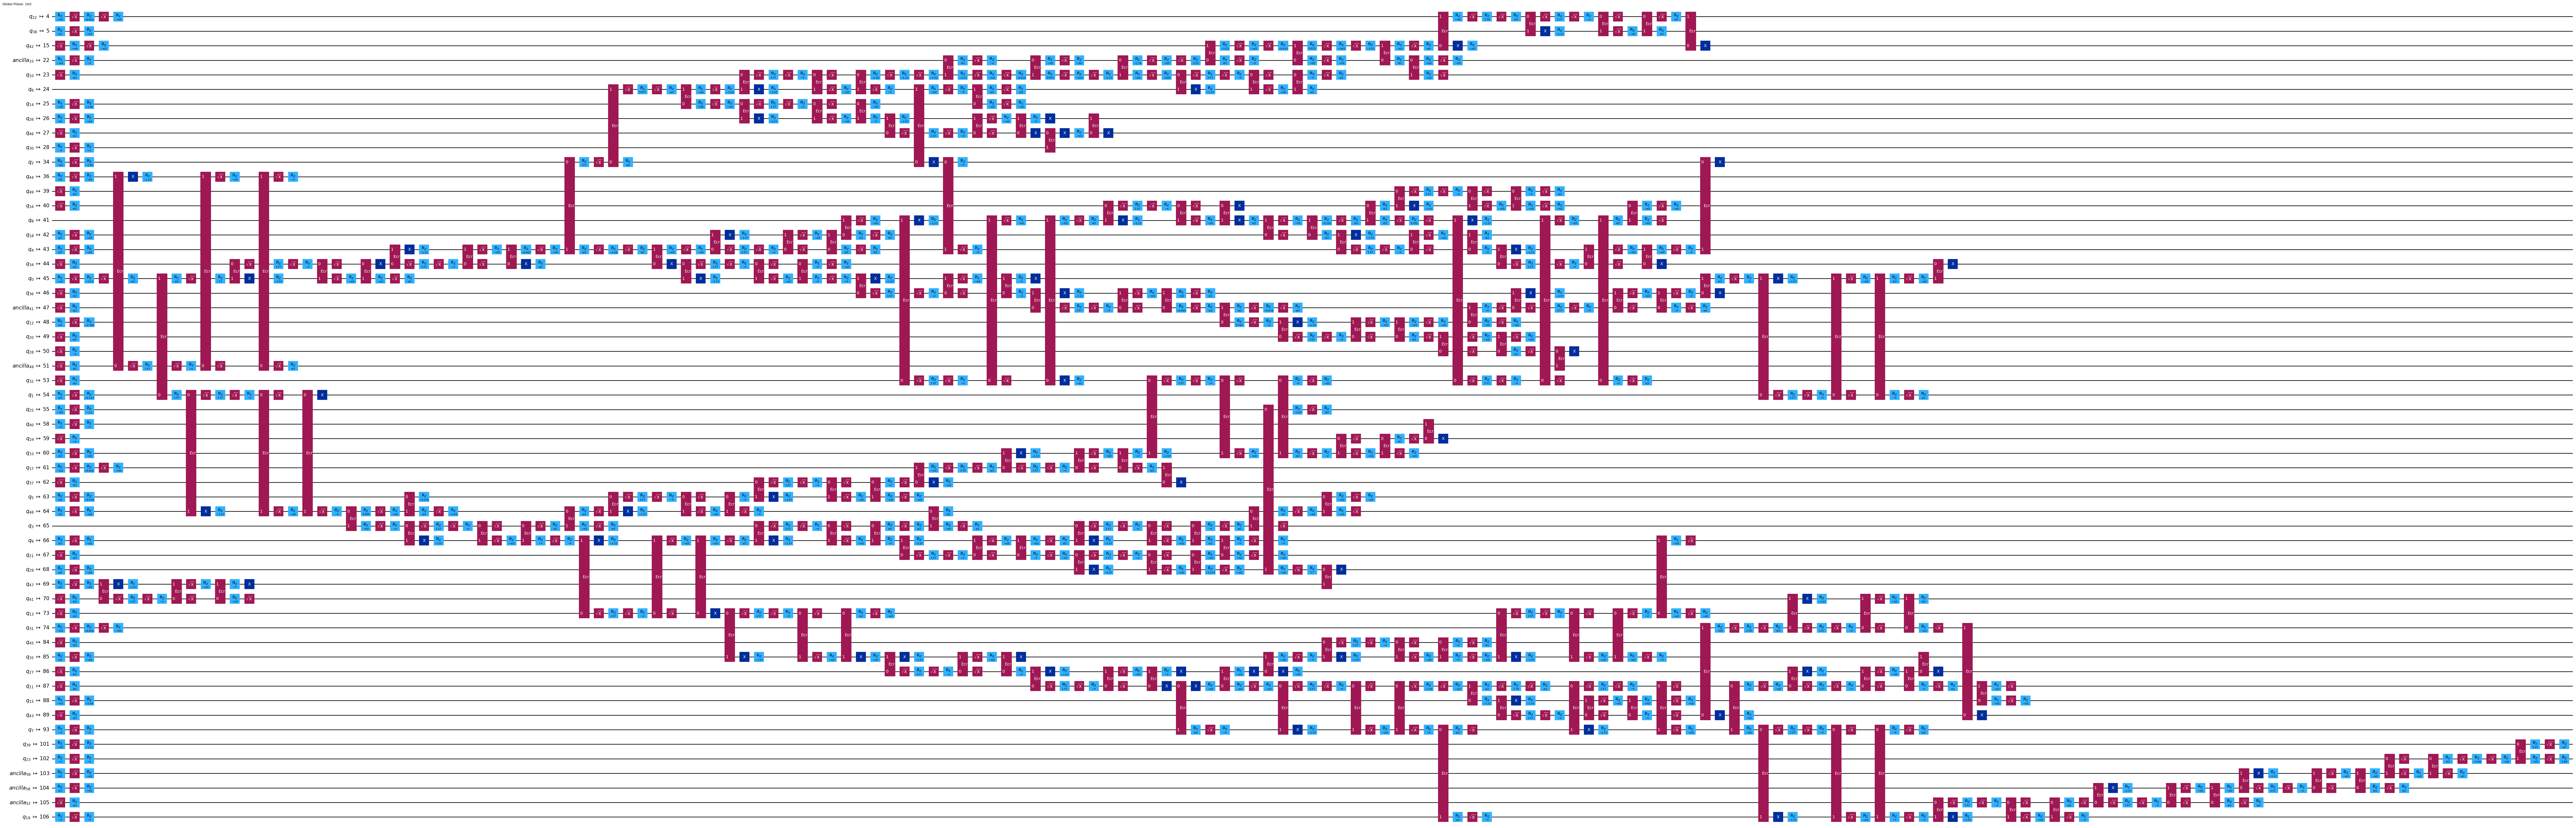

In [11]:
# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

qc = ghz(50)

#qc.draw()

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
#transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [29]:
import rustworkx as rx
from rustworkx.visit import BFSVisitor
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

class TreeEdgesRecorder(BFSVisitor):
    def __init__(self):
        self.edges = []

    def tree_edge(self, edge):
        self.edges.append(edge)


# Coupling map of the backend
coupling_map = backend.coupling_map
edges = list(coupling_map.get_edges())

#print (coupling_map[0])
#print (edges)

# Create a graph from the layout
G = rx.PyGraph()
indices = G.add_nodes_from(range(127))
for edge in edges:
    G.add_edge(edge[0], edge[1], None)

# Preparing registers and Quantum Circuit
qr = QuantumRegister(127)
cr = ClassicalRegister(127)
qc = QuantumCircuit(qr, cr)

source_vertex = 12  # Root node
vis = TreeEdgesRecorder()
rx.bfs_search(G, [source_vertex], vis)  # Run the BFS algorithm

# Create GHZ-State
qc.h(qr[source_vertex])
for edge in vis.edges:
    u, v, _ = edge
    #print (f' u = %d v = %d' % (u,v))
    qc.cx(qr[u], qr[v])

#qc.draw()

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

#qc.draw()

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))

Depth of two-qubit gates:  31
